In [1]:
using NBInclude
@nbinclude("julia_function.ipynb")

allskyevents_free_eres (generic function with 1 method)

In [77]:
xs = model_2[:, 24]
ys = model_2[:, 25]
zs = model_2[:, 26]

tuples = [zeros(3) for _ in 1:numv]

for i in 1:numv
        tuples[i] = [xs[i], ys[i], zs[i]]
        # tuples[i][2] = ys[i]
        # tuples[i][3] = zs[i]
end

function galcoord(carttuple)
    x, y, z = carttuple
    r = sqrt((8-x)^2 + y^2 + z^2)
    l = atan(y, (8-x))
    b = asin(z / r)
    
    # Convert l from [-π, π] to [0, 2π]
    # l = (l < 0) ? (2π + l) : l

    return [r, l, b]

end

for i in 1:numv
    tuples[i] .= galcoord(tuples[i])
end

rs, ls, bs = zeros(numv), zeros(numv), zeros(numv)

for i in 1:numv
    rs[i] = tuples[i][1]
    ls[i] = tuples[i][2]
    bs[i] = tuples[i][3]
end

# We now have what we started with, but in galactic coordinates. Let's bin by r, l, and b:

rbinsize = 0.1
θbinsize = π/100

rbins, lbins, bbins = rbinsize:rbinsize:20+rbinsize, -π:θbinsize:π, -π/2:θbinsize:π/2

nubins_galcoord = fit(Histogram, (rs, ls, bs), (rbins, lbins, bbins), closed=:left)


Histogram{Int64, 3, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}
edges:
  0.1:0.1:20.1
  -3.141592653589793:0.031415926535897934:3.1101767270538954
  -1.5707963267948966:0.031415926535897934:1.5393804002589988
weights: [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; … ;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
closed: left
isdensity: false

In [102]:
binvals = nubins_galcoord.weights
redges = view(collect(rbins), 1:length(rbins)-1)
ledges = view(collect(lbins), 1:length(lbins)-1)
bedges = view(collect(bbins), 1:length(bbins)-1)

# Interpolating the distribution to get a continuous function, and assuming zero neutrinos outside the sampled window
pds = Interpolations.interpolate((redges, ledges, bedges), binvals, Gridded(Linear()))
νinterp = extrapolate(pds, 0.0)

200×199×99 extrapolate(interpolate((view(::Vector{Float64}, 1:200),view(::Vector{Float64}, 1:199),view(::Vector{Float64}, 1:99)), ::Array{Int64, 3}, Gridded(Linear())), 0.0) with element type Float64:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0

In [107]:
array = [2, 3, 4]
for (i, val) in enumerate(array)
    print(i)
    print(val)
end

122334

In [110]:
rsample = 0:0.05:20
lsample = -π:π/200:π
bsample = -π/2:π/200:π/2

samplegrid = zeros(length(rsample), length(lsample), length(bsample))

for (i, r) in enumerate(rsample)
    for (j, l) in enumerate(lsample)
        for (k, b) in enumerate(bsample)
            samplegrid[i, j, k] = νinterp(r, l, b)
        end
    end
end

In [111]:
nuweights = nubins_galcoord.weights
newarray = zeros(size(nuweights))

for i in 1:length(rbins)-1
    for j in 1:length(lbins)-1
        for k in 1:length(bbins)-1
            # newarray[i, j, k] = nuweights[i, j, k] * sbinarea((rbins[i]+0.01), lbins[j], bbins[k], θbinsize) * rbinsize * (1/(rbins[i]+0.01)^2)
            newarray[i, j, k] = nuweights[i, j, k] * (1/(rbins[i]+0.05)^2)
        end 
    end
end

In [112]:
maximum(newarray)
maximum(nuweights)

42

In [113]:
nuweights[:, 1, 1]

200-element Vector{Int64}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [114]:
# Create a new 99x199 matrix to store the sums
unsmearedlos = zeros(Float64, 99, 199)

# Compute the sum of each 200-length vector and populate the sum_matrix
for i in 1:99
    for j in 1:199
        unsmearedlos[i, j] = sum(newarray[:, j, i])
    end
end

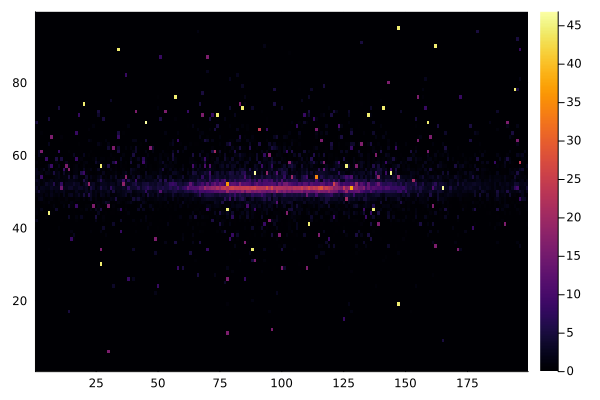

In [115]:
heatmap(unsmearedlos)

In [41]:
# Sample index ranges for l and b axes
l_start_index = 95
l_end_index = 105
b_start_index = 48
b_end_index = 52

# Create index arrays for l and b
l_indices = l_start_index:l_end_index
b_indices = b_start_index:b_end_index

# Use array indexing to select elements based on index ranges for l and b
selected_elements = newarray[:, l_indices, b_indices]

300×11×5 Array{Float64, 3}:
[:, :, 1] =
 0.0      0.0  0.0       0.0       0.0  …  0.0  0.0       0.0  0.0   0.0
 0.0      0.0  0.0       0.0       0.0     0.0  0.0       0.0  0.0   0.0
 0.0      0.0  0.0       0.0       0.0     0.0  0.0       0.0  0.0   0.0
 0.0      0.0  0.0       0.0       0.0     0.0  0.0       0.0  0.0   0.0
 0.0      0.0  0.0       0.0       0.0     0.0  0.0       0.0  0.0   0.0
 0.0      0.0  0.0       0.0       0.0  …  0.0  0.0       0.0  0.0   0.0
 0.0      0.0  0.0       0.0       0.0     0.0  0.0       0.0  0.0   0.0
 0.0      0.0  0.0       1.77778   0.0     0.0  0.0       0.0  0.0   0.0
 0.0      0.0  0.0       0.0       0.0     0.0  0.0       0.0  0.0   0.0
 1.10803  0.0  0.0       0.0       0.0     0.0  0.0       0.0  0.0   0.0
 0.0      0.0  0.907029  0.0       0.0  …  0.0  0.907029  0.0  0.0   0.907029
 1.51229  0.0  0.756144  0.756144  0.0     0.0  0.0       0.0  0.0   0.0
 0.0      0.0  0.0       0.0       0.0     0.0  0.0       0.0  0.64  0.0
 ⋮    

In [42]:
los = vec(sum(selected_elements, dims=(2, 3)))

300-element Vector{Float64}:
 0.0
 0.0
 0.0
 8.163265306122451
 4.938271604938271
 3.305785123966942
 4.733727810650887
 8.88888888888889
 9.68858131487889
 6.648199445983378
 9.977324263038549
 9.829867674858223
 4.48
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

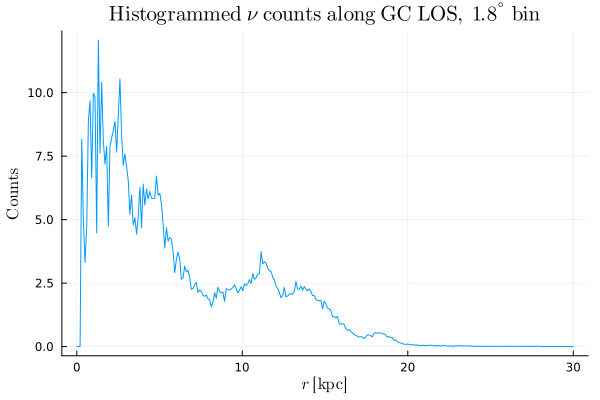

In [43]:
plot(
    range(0, 30, length(rbins)-1),
    los,
    xlabel=L"r~[\mathrm{kpc}]",
    ylabel=L"\mathrm{Counts}",
    label=false,
    title=L"\mathrm{Histogrammed~\nu~counts~along~GC~LOS,~}1.8^{\circ}\mathrm{~bin}"
)

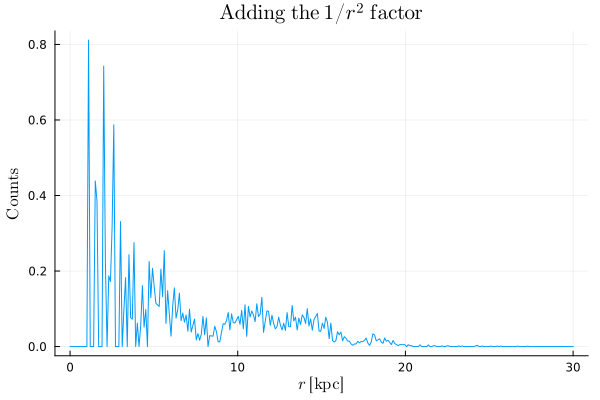

In [470]:
plot(
    range(0, 30, length(rbins)-1),
    newarray[:, 100, 50],
    xlabel=L"r~[\mathrm{kpc}]",
    ylabel=L"\mathrm{Counts}",
    label=false,
    title=L"\mathrm{Adding~the}~1/r^2~\mathrm{factor}"
)

In [465]:
avgdists = zeros(length(bbins), length(lbins))
for j in 1:length(lbins)-1
    for i in 1:length(bbins)-1
        if sum(newarray[:, j, i]) > 0
            avgdists[i, j] = sum(newarray[:, j, i] .* rbins[1:end-1]) / sum(newarray[:, j, i])
        else
            avgdists[i, j] = sum(newarray[:, j, i] .* rbins[1:end-1])
        end
    end
end
sum(avgdists)

8104.489545177959

In [482]:
new_nuweights = zeros(length(bbins), length(lbins))
new_newarray = zeros(length(bbins), length(lbins))
for j in 1:length(lbins)-1
    for i in 1:length(bbins)-1
        new_nuweights[i, j] = sum(nuweights[:, j, i])
        new_newarray[i, j] = sum(newarray[:, j, i])
    end
end

new_nuweights

100×200 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

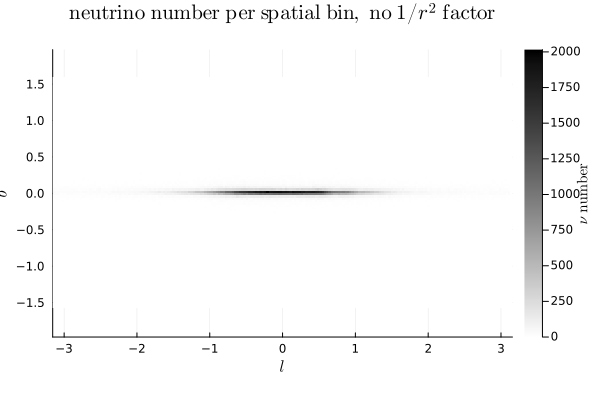

In [493]:
heatmap(
    range(-π, π, length(lbins)),
    range(-π/2, π/2, length(bbins)),
    new_nuweights, 
    xlabel=L"l",
    ylabel=L"b",
    colorbar_title=L"\nu~\mathrm{number}",
    title=L"\mathrm{neutrino~number~per~spatial~bin,~no~}1/r^2~\mathrm{factor}",
    aspect_ratio=1,
    c=:grayC
)

In [113]:
#=
# Packages
using Plots
using LaTeXStrings
using FFTW
using Distributions
using Profile
using PyCall
using SpecialFunctions
using Optim
using Healpix
using BenchmarkTools

# Importing the necessary python libraries
@pyimport matplotlib.pyplot as plt
@pyimport numpy as np
@pyimport healpy as hp

include("base_functions.jl")
=#

In [116]:
# Getting the true energy resolution matrix

true_eres = readdlm("gc_data/eres_matrix.dat")
true_eres[1:25, 175:end] = zeros(25, 26)

true_eres = 10 .^ true_eres

for j in 1:200
    for i in 1:200
        if true_eres[i, j] == 1
            true_eres[i, j] = 0
        end
    end
end

erestrue = transpose(true_eres)

loges = range(log10(5e-1), log10(4e3), 200)
du = loges[2] - loges[1];

# eresnorm = (1/0.11711890233208494) # Needed to actually normalize the columns, not precise (might have to go about being more precise here)

In [117]:
# sum(erestrue[:,100]*du)
# Normalizing the columns
for i in 1:200
    normconst = sum(erestrue[:,i]*du)
    erestrue[:,i] .= erestrue[:,i]/normconst
end

In [118]:
dm2 = 10^(-13.8)
ers = 10 .^ loges
rbins = range(0, 30, 300)

# Effective area vector

effareavec = effarea.(ers) * 10000

# osc prob matrix

oscprobmat = [oscprob(er, dm2, rbin) for rbin in rbins, er in ers]

# spatial dist vector

# Sample index ranges for l and b axes
ilmin, ilmax = 95, 105
ibmin, ibmax = 48, 52

l_start_index = 92
l_end_index = 102
b_start_index = 48
b_end_index = 52

# Create index arrays for l and b
l_indices = ilmin:ilmax
b_indices = ibmin:ibmax

# Use array indexing to select elements based on index ranges for l and b
selected_elements = newarray[:, l_indices, b_indices]

spacedistvec = vec(sum(selected_elements, dims=(2, 3)))

# E dependence vector

200-element Vector{Float64}:
  0.0
  0.0
  8.163265306122451
  4.938271604938271
  3.305785123966942
  4.733727810650887
  8.88888888888889
  9.68858131487889
  6.648199445983378
  9.977324263038549
  9.829867674858223
  4.48
 12.071330589849104
  ⋮
  0.36201363120557495
  0.35271181653474415
  0.2508708901144598
  0.25906560971496034
  0.19496691571687064
  0.16124662142068846
  0.1465191881267129
  0.12172302831355333
  0.09229290177856111
  0.09390326694541554
  0.09296424017437077
  0.09203922861176235

In [167]:
function dm2stuff(dm2)
    ers = 10 .^ loges
    rbins = range(0, 20, 200)

    effareavec = effarea.(ers) * 10000
    oscprobmat = [oscprob(er, dm2, rbin) for rbin in rbins, er in ers]

    return oscprobmat .* transpose(effareavec)

end

function spatialstuff(ilmin, ilmax, ibmin, ibmax)

    l_indices = ilmin:ilmax
    b_indices = ibmin:ibmax

    selected_elements = newarray[:, l_indices, b_indices]

    spacedistvec = vec(sum(selected_elements, dims=(2, 3)))

end

spatialstuff (generic function with 1 method)

In [207]:
function anglesmear_spacedist(res)
    
    bsize = π/100

    # Healpix angle labeling scheme
    θedges = (bsize):bsize:(π-bsize)
    ϕedges = bsize:bsize:(2π-bsize)

    # Convert to galactic coordinate angle scheme
    b_range = (θedges .- π/2)
    l_range = ϕedges


    skyedistbins = [zeros(200) for _ in 1:99, _ in 1:199]
    for bi in 1:99
        for li in 1:199
            if li <= 100
                skyedistbins[bi, li] = spatialstuff(li+99, li+99, bi, bi)
            else
                skyedistbins[bi, li] = spatialstuff(li-100, li-100, bi, bi)
            end
        end
    end

    edistvals1 = transpose(skyedistbins)

    # Splitting the data into all-sky maps for each energy bin
    matrix = zeros(length(l_range), length(b_range))
    ebins = [copy(matrix) for _ in 1:200]
    for i in 1:200
        for j in 1:length(l_range)
            for k in 1:length(b_range)
                ebins[i][j, k] = edistvals1[j, k][i]
            end
        end
    end

    # Converting from angles to the appropriate pixels in the Healpix scheme
    nside = 128
    npix = hp.nside2npix(nside)
    theta, phi = np.meshgrid(θedges, ϕedges)
    pixel_indices = hp.ang2pix(nside, vec(theta), vec(phi)) .+ 1 # the addition is for changing indexing to Julia indexing

    # Function that converts a smoothed healpix map to a 2d array/matrix 
    function conv(map)
        mat_smoothed = zeros(npix, 3)

        for i in 1:npix
            θ, ϕ = Healpix.pix2ang(map, i) # The Julia Healpix.jl package does this a lot faster than healpy
            mat_smoothed[i, 1] = θ - π/2
            if ϕ < π
                mat_smoothed[i, 2] = ϕ
            else
                mat_smoothed[i, 2] = ϕ - 2π
            end
            mat_smoothed[i, 3] = map[i]
        end
        return mat_smoothed
    end

    # Function that does the actual angular smearing with healpy
    function smoothing(emap, i, res)

        bin = emap[i]
        e = []

        for (j, thval) in enumerate(θedges)
            for (i, phval) in enumerate(ϕedges)
                    push!(e, bin[i, j])
            end
        end

        E = np.zeros(hp.nside2npix(nside))

        E[pixel_indices] = e

        E_smoothing = hp.smoothing(E, fwhm=np.radians(res))

        # Initializing a Julia healpix map so we can use conv
        hpmap = Healpix.HealpixMap{Float64, Healpix.RingOrder}(E_smoothing)

        mat_smoothed = conv(hpmap)

        # Rebinning to match the initial sampling resolution
        bbins = (-π/2):bsize:(π/2)
        lbins = (-π):bsize:(π)
        binned = fit(Histogram, (mat_smoothed[:, 1], mat_smoothed[:, 2]), weights(mat_smoothed[:, 3]), (bbins, lbins), closed=:right)

        return binned.weights
    end

    # We return a vector with smeared skymaps for each energy bin
    smearedebins = [smoothing(ebins, i, res) for i in 1:200]

    bbins = size(smearedebins[1])[1]
    lbins = size(smearedebins[1])[2]

    allskyedists = [zeros(200) for _ in 1:bbins, _ in 1:lbins]

    for i in 1:bbins
        for j in 1:lbins
            allskyedists[i, j] = [smearedebins[k][i, j] for k in 1:200]
        end
    end

    return allskyedists

end

anglesmear_spacedist (generic function with 2 methods)

In [208]:
smearedspacedists = anglesmear_spacedist(7)

skyedistbins = allskyspacedists()

# Create a new 99x199 matrix to store the sums
smearedlos = zeros(Float64, 99, 199)
unsmearedlos = zeros(Float64, 99, 199)

# Compute the sum of each 200-length vector and populate the sum_matrix
for i in 1:99
    for j in 1:199
        smearedlos[i, j] = sum(smearedspacedists[i, j])
        unsmearedlos[i, j] = sum(skyedistbins[i, j])
    end
end

In [218]:
smearedlos

99×199 Matrix{Float64}:
 0.0          0.0          0.0          …  0.0          0.0
 0.0          0.0          0.000441891     0.000124571  0.0
 0.0          0.00191454   0.00207671      0.000901766  0.000975224
 0.0          0.00563198   0.0             0.0          0.00308363
 0.0          0.0049127    0.0             0.0          0.00278079
 0.00288499   0.0          0.00492043   …  0.000682178  0.000426914
 0.00116337   0.0          0.00198855      0.000375203  0.0
 0.000323348  0.000130163  0.000423695     8.02903e-5   2.47193e-5
 6.18881e-5   0.000106185  6.77535e-5      4.40395e-6   2.02159e-5
 8.15817e-6   1.40247e-5   2.37657e-5      1.56292e-6   2.67875e-6
 8.04942e-7   1.43124e-6   2.50977e-6   …  1.45629e-7   2.50572e-7
 7.46978e-7   1.5698e-6    3.16343e-6      6.70647e-8   1.52064e-7
 2.55169e-6   8.8643e-6    3.00148e-5      2.16215e-7   5.44194e-7
 ⋮                                      ⋱               
 0.0787074    0.0757791    0.0917256       0.196095     0.114136
 0

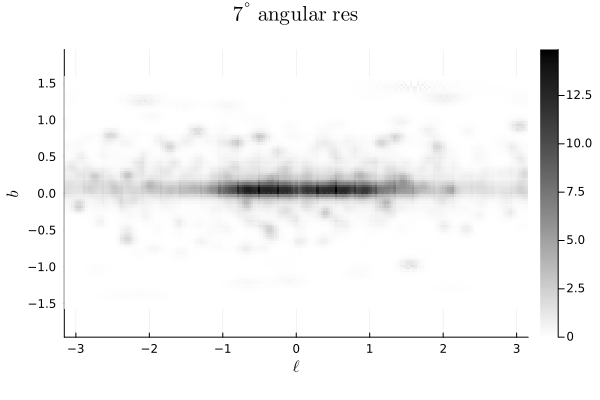

In [229]:
heatmap(
    range(-π, π, 199),
    range(-π/2, π/2, 99),
    smearedlos,
    xlabel=L"\ell",
    ylabel=L"b",
    title=L"7^{\circ}~\mathrm{angular~res}",
    c=:grayC,
    aspect_ratio=1
)

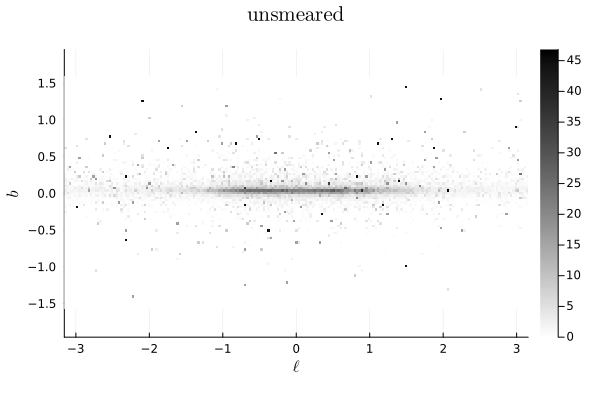

In [228]:
heatmap(
    range(-π, π, 199),
    range(-π/2, π/2, 99),
    unsmearedlos,
    xlabel=L"\ell",
    ylabel=L"b",
    title=L"\mathrm{unsmeared}",
    c=:grayC,
    aspect_ratio=1
)

In [163]:
function smearedspatialstuff(ilmin, ilmax, ibmin, ibmax)

    l_indices = ilmin:ilmax
    b_indices = ibmin:ibmax

    selected_elements = smearedspacedists[b_indices, l_indices]

    spacedistvec = sum(selected_elements, dims=(2, 3))
    
    float_vector = Vector{Float64}(spacedistvec[1])

end

smearedspatialstuff (generic function with 1 method)

In [169]:
function edepflux(ers, ϕ₀, γ)
    e0 = 100.0 # TeV
    as = ϕ₀ * (ers/e0) .^ (-γ) * 3.156e-8
end

function ubsmedist(dm2, ϕ₀, γ)
    ers = 10 .^ loges
    bigmat = smearedspatialstuff(ilmin, ilmax, ibmin, ibmax) .* dm2stuff(dm2)
    bigvec = vec(sum(bigmat, dims=1)) .* edepflux(ers, ϕ₀, γ)
    return erestrue * bigvec * du
end

function smedistbinnednew(dm2, ϕ₀, γ)
    unbinned_vec = ubsmedist(dm2, ϕ₀, γ)
    nbins = 25 # An admittedly arbitrary number of bins, should probably find a more intelligent number
    nsteps = 200
    steps = unbinned_vec .* du .* (10 .^ loges) .* log(10)
    matrix = reshape(steps, (8, :)) # This 8 is the ratio nsteps/nbins
    sums = sum(matrix, dims=1)
    νbins = vec(sums) * 303.3578031561753 * 0.11355741692030315 # This factor is to make the total sum over all sky to be 748
end

smedistbinnednew (generic function with 1 method)

In [170]:
ilmin, ilmax = 50, 54
ibmin, ibmax = 45, 55

ers = 10 .^ loges
bigmat = smearedspatialstuff(ilmin, ilmax, ibmin, ibmax) .* dm2stuff(10^(-14))
bigvec = vec(sum(bigmat, dims=1)) .* edepflux(ers, 21.8, 2.7)
test1 = erestrue * bigvec * du

bigbigmat = transpose(transpose(erestrue) .* vec(sum(bigmat, dims=1))) * du

test2 = bigbigmat * edepflux(ers, 21.8, 2.7)

200-element Vector{Float64}:
 333.1423893524511
 462.5122584869902
 462.5122584869902
 462.5122584869902
 462.5122584869902
 462.5122584869902
 462.5122584869902
 613.2630100513553
 613.2630100513553
 613.2630100513553
 613.2630100513553
 613.2630100513553
 613.2630100513553
   ⋮
   1.672853060908877e-5
   1.672853060908877e-5
   1.672853060908877e-5
   1.672853060908877e-5
   1.672853060908877e-5
   1.672853060908877e-5
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0

In [16]:
function edependencetest(ϕ₀, γ)
    ers = 10 .^ loges
    return bigbigmat * edepflux(ers, ϕ₀, γ)
end;

In [18]:
@time edependencetest(21.8, 2.7)

  0.000133 seconds (11 allocations: 10.812 KiB)


200-element Vector{Float64}:
 5195.76194532837
 7227.835886482492
 7227.835886482492
 7227.835886482492
 7227.835886482492
 7227.835886482492
 7227.835886482492
 9527.076521989495
 9527.076521989495
 9527.076521989495
 9527.076521989495
 9527.076521989495
 9527.076521989495
    ⋮
    0.00033700708577386464
    0.00033700708577386464
    0.00033700708577386464
    0.00033700708577386464
    0.00033700708577386464
    0.00033700708577386464
    0.0
    0.0
    0.0
    0.0
    0.0
    0.0

In [21]:
@time smedistbinnednew(0, 21.8, 2.7)

  0.004992 seconds (73 allocations: 1.025 MiB)


25-element Vector{Float64}:
  91999.93648281517
 151752.67822935613
 160945.07055484792
 165993.27379724482
 153858.77678116865
 136646.18688946834
 110637.18242872966
  88563.40630942206
  71308.2161151497
  62858.429426846174
  54222.116449586494
  42913.92455910783
  34004.8029579723
  23656.894886182796
  18789.824620002742
  13632.339479416229
   8133.199601045224
   5748.574653671022
   3868.4131822951817
   2468.0216292961936
   1509.9719613824127
    487.3124352527151
     11.295480656149314
      8.106275353723735
      3.12820782923884

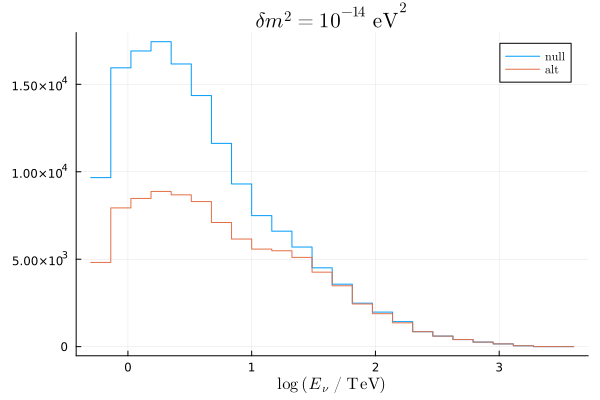

In [176]:
ilmin, ilmax = 100, 100
ibmin, ibmax = 50, 50

binnedus = range(log10(5e-1), log10(4e3), 25)

plot(
    binnedus,
    [smedistbinnednew(0, 21.8, 2.7) smedistbinnednew(10^(-13.6), 21.8, 2.7)],
    seriestype=:step,
    xlabel=L"\log~(E_{\nu}~/~\mathrm{TeV})",
    label=[L"\mathrm{null}" L"\mathrm{alt}"],
    title=L"\delta m^2 = 10^{-14}~\mathrm{eV}^2"
)

In [175]:
@time smedistbinnednew(0, 21.8, 2.7)

  0.004385 seconds (86 allocations: 967.750 KiB)


25-element Vector{Float64}:
  9665.647995778529
 15943.358509335321
 16909.124702814108
 17439.4963249866
 16164.628306081764
 14356.248416385346
 11623.704335932734
  9304.601105391883
  7491.745565549203
  6603.998607334585
  5696.654924166296
  4508.599731296674
  3572.5943747685424
  2485.4280055474574
  1974.0864789975576
  1432.2335406351574
   854.4858554091904
   603.953667839949
   406.4211514893702
   259.2939650474729
   158.6398645497314
    51.19775777234567
     1.1867197319843625
     0.8516571545740611
     0.32865409358960773

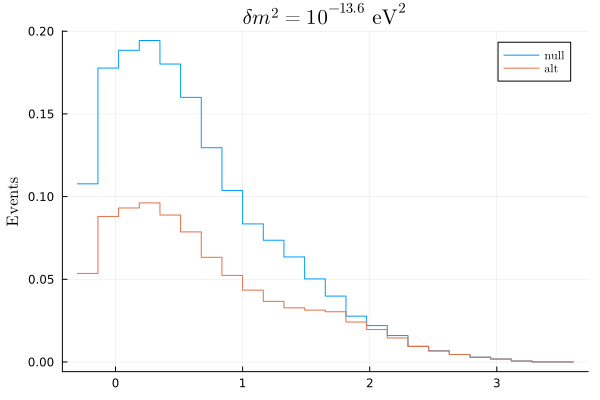

In [210]:
l0, b0 = 0, 0

plot(
    binned_us,
    [smedistbinned(0, l0, b0, 21.8, 2.7, π/100) smedistbinned(10^(-13.2), l0, b0, 21.8, 2.7, π/100)],
    seriestype=:step,
    ylabel=L"\mathrm{Events}",
    title=L"\delta m^2 = 10^{-13.6}~\mathrm{eV^2}",
    label=[L"\mathrm{null}" L"\mathrm{alt}"]
)

In [133]:
# New event distribution function

function smedist(dm2, l, b, ϕ₀, γ, θ)

    # Mutates emptymat and ur
    function fstrippedmat!(emptymat, ur, dm2, l, b, θ, ϕ₀, γ)
        ur .= 10 .^ ur
        r0, rmax = 0.2, 20.2
        blength = 0.2
        rbins = range(r0, stop=rmax, step=blength)
        for i in 1:length(ur)
            for j in 1:length(rbins)
                vols = blength * oscprob(ur[i], dm2, rbins[j]) * sbinarea(rbins[j], l, b, θ) * (1/(rbins[j]^2))
                emptymat[j, i] = vols
            end 
        end
        flx = fluxfreeparams1(ur, cartx.(rbins, l, b), carty.(rbins, l, b), cartz.(rbins, l, b), ϕ₀, γ)
        vec(sum(flx .* emptymat, dims=1)) .* (effarea.(ur) * 10000)
    end

    emptymat = zeros(101, length(loges)) # 61 from the sampling frequency along r
    fsample = fstrippedmat!(emptymat, collect(loges), dm2, l, b, θ, ϕ₀, γ)

    fsmeared = erestrue * fsample * du
end

# For binned edist:
function smedistbinned(dm2, l, b, ϕ₀, γ, θ)
    unbinned_vec = smedist(dm2, l, b, ϕ₀, γ, θ)
    nbins = 25 # An admittedly arbitrary number of bins, should probably find a more intelligent number
    nsteps = 200
    steps = unbinned_vec .* du .* (10 .^ loges) .* log(10)
    matrix = reshape(steps, (8, :)) # This 8 is the ratio nsteps/nbins
    sums = sum(matrix, dims=1)
    νbins = vec(sums) * 303.3578031561753 * 0.11355741692030315 # This factor is to make the total sum over all sky to be 748
end

smedistbinned (generic function with 1 method)

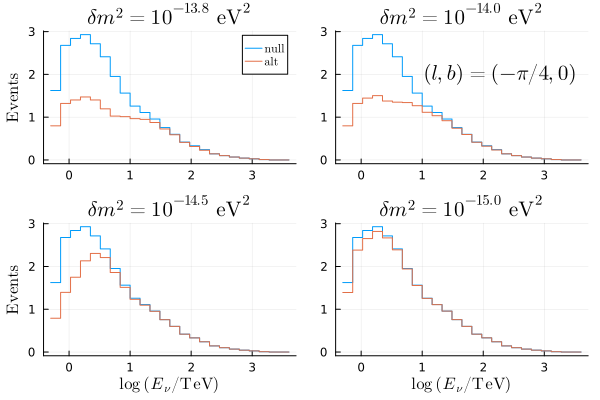

In [202]:
# Plotting different dm2 values

l0 = 0
b0 = 0

nullsmear = smedistbinned(0, l0, b0, 21.8, 2.7, 0.122)
binned_us = range(log10(5e-1), log10(4e3), 25)
p135 = plot(
    binned_us,
    [nullsmear smedistbinned(10^(-13.8), l0, b0, 21.8, 2.7, 0.122)],
    seriestype=:step,
    ylabel=L"\mathrm{Events}",
    title=L"\delta m^2 = 10^{-13.8}~\mathrm{eV^2}",
    label=[L"\mathrm{null}" L"\mathrm{alt}"]
)

p140 = plot(
    binned_us,
    [nullsmear smedistbinned(10^(-14), l0, b0, 21.8, 2.7, 0.122)],
    seriestype=:step,
    title=L"\delta m^2 = 10^{-14.0}~\mathrm{eV^2}",
    label=false,
    ann=[(2.3, 2.0, L"(l, b) = (-\pi/4, 0)")]
)

p145 = plot(
    binned_us,
    [nullsmear smedistbinned(10^(-14.5), l0, b0, 21.8, 2.7, 0.122)],
    seriestype=:step,
    xlabel=L"\log~(E_{\nu}/\mathrm{TeV})",
    ylabel=L"\mathrm{Events}",
    title=L"\delta m^2 = 10^{-14.5}~\mathrm{eV^2}",
    label=false
)

p150 = plot(
    binned_us,
    [nullsmear smedistbinned(10^(-15), l0, b0, 21.8, 2.7, 0.122)],
    seriestype=:step,
    xlabel=L"\log~(E_{\nu}/\mathrm{TeV})",
    title=L"\delta m^2 = 10^{-15.0}~\mathrm{eV^2}",
    label=false
)

plot(p135, p140, p145, p150, layout=(2, 2))

In [121]:
spatialstuff(199, 199, 99, 99)

300-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [132]:
function asubsmedist(dm2, ϕ₀, γ)
    spacedists = allskyspacedists()
    ers = 10 .^ loges
    dm2shit = dm2stuff(dm2)
    bigmat = [sum(spacevec .* dm2shit, dims=1) for spacevec in spacedists]
    bigvec = [mat .* edepflux(ers, ϕ₀, γ) for mat in bigmat]
    return [erestrue * vec * du for vec in bigvec]
end

function assmedistbinnednew(dm2, ϕ₀, γ)
    unbinned_vec = ubsmedist(dm2, ϕ₀, γ, spacevec)
    nbins = 25 # An admittedly arbitrary number of bins, should probably find a more intelligent number
    nsteps = 200
    steps = unbinned_vec .* du .* (10 .^ loges) .* log(10)
    matrix = reshape(steps, (8, :)) # This 8 is the ratio nsteps/nbins
    sums = sum(matrix, dims=1)
    νbins = vec(sums) * 303.3578031561753 * 0.11355741692030315 # This factor is to make the total sum over all sky to be 748
end

assmedistbinnednew (generic function with 1 method)

In [ ]:
#=
ers = 10 .^ loges
bigmat = spatialstuff(ilmin, ilmax, ibmin, ibmax) .* dm2stuff(10^(-14))
bigvec = vec(sum(bigmat, dims=1)) .* edepflux(ers, 21.8, 2.7)
test1 = erestrue * bigvec * du

bigbigmat = transpose(transpose(erestrue) .* vec(sum(bigmat, dims=1))) * du

test2 = bigbigmat * edepflux(ers, 21.8, 2.7)
=#

In [210]:
function allskyspacedists()
    skyedistbins = [zeros(200) for _ in 1:99, _ in 1:199]
    for bi in 1:99
        for li in 1:199
            skyedistbins[bi, li] = smearedspatialstuff(li, li, bi, bi)
        end
    end
    return skyedistbins
end

allskyspacedists (generic function with 1 method)

In [211]:
smearedspatialstuff(1, 1, 1, 1)

200-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [214]:
function testasstuff()
    
    spacedists = allskyspacedists()
    dm2shit = dm2stuff(0)

    newmat = [zeros(200, 200) for _ in 1:99, _ in 1:199]

    for i in 1:99
        for j in 1:199
            bigmat = spacedists[i, j] .* dm2shit
            newmat[i, j] = transpose(transpose(erestrue) .* vec(sum(bigmat, dims=1))) * du
        end
    end

    return newmat
end

testasstuff (generic function with 1 method)

In [215]:
bigmatrix = testasstuff()

99×199 Matrix{Matrix{Float64}}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]  …  [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]     [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]     [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]     [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]     [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]  …  [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 

In [257]:
function assmedistbinnednew(vec, dm2, ϕ₀, γ)
    nbins = 25 # An admittedly arbitrary number of bins, should probably find a more intelligent number
    nsteps = 200
    steps = vec .* du .* (10 .^ loges) .* log(10)
    matrix = reshape(steps, (8, :)) # This 8 is the ratio nsteps/nbins
    sums = sum(matrix, dims=1)
    # return vec(sums) # This factor is to make the total sum over all sky to be 748
end

assmedistbinnednew (generic function with 2 methods)

In [258]:
ubvec = bigmatrix[1, 1]*edepflux(ers, 21.8, 2.7)

200-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [259]:
assmedistbinnednew(ubvec, 0, 21.8, 2.7)

1×25 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [261]:
edistmat = [zeros(200) for _ in 1:99, _ in 1:199]
binnededistmat = [zeros(25) for _ in 1:99, _ in 1:199]

for i in 1:99
    for j in 1:199
        unbinnedvec = bigmatrix[i, j] * edepflux(ers, 21.8, 2.7)
        edistmat[i, j] = unbinnedvec
        binnededistmat[i, j] = vec(assmedistbinnednew(unbinnedvec, 0, 21.8, 2.7))
    end
end

In [232]:
edistmat[50, 100]

200-element Vector{Float64}:
  776.9592562053532
 1081.2774913343821
 1081.2774913343821
 1081.2774913343821
 1081.2774913343821
 1081.2774913343821
 1081.2774913343821
 1388.8443241771233
 1388.8443241771233
 1388.8443241771233
 1388.8443241771233
 1388.8443241771233
 1388.8443241771233
    ⋮
    2.935945203703946e-5
    2.935945203703946e-5
    2.935945203703946e-5
    2.935945203703946e-5
    2.935945203703946e-5
    2.935945203703946e-5
    0.0
    0.0
    0.0
    0.0
    0.0
    0.0

In [164]:
@time testasstuff()

274.256806 seconds (118.24 k allocations: 17.618 GiB, 87.93% gc time, 0.04% compilation time)


99×199 Matrix{Matrix{Float64}}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]  …  [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]     [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]     [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]     [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]     [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]  …  [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 

In [203]:
function allskyevents2(dm2, ϕ₀, γ, nb)
    bsize = π/nb

    b_range = (-π/2+bsize):bsize:(π/2-bsize)
    l_range = (0+bsize/2):bsize:(2π-bsize/2)

    # Going to be a vector of vectors
    skybins = [zeros(25) for _ in 1:length(b_range), _ in 1:length(l_range)]

    for (j, l) in enumerate(l_range)
        for (i, b) in enumerate(b_range)
            if i > nb/4 && i < 3*nb/4
                skybins[i, j] = smedistbinned(dm2, l, (-b), ϕ₀, γ, bsize)
            end
        end
    end

    return sum(skybins)
end

allskyevents2 (generic function with 1 method)

In [204]:
testasevents = allskyevents2(0, 21.8, 2.7, 100)

25-element Vector{Float64}:
 49.01347515579265
 80.8470789065043
 85.74437677531257
 88.4338349821542
 81.96911456208537
 72.79901206770718
 58.942571045039344
 47.18264469313034
 37.989846651868405
 33.48817604477759
 28.88713252527868
 22.862630732449272
 18.116246909252204
 12.603341633651072
 10.01038302201689
  7.262704279306833
  4.333007084818964
  3.0625849510401997
  2.0609185250707442
  1.3148521774693116
  0.8044459164271774
  0.2596183959630152
  0.006017729812414866
  0.004318663043098601
  0.0016665700280042437

In [205]:
sum(testasevents)

747.9999999999999

In [134]:
function anglesmear_realeres(dm2, ϕ₀, γ, res, nb)

    bsize = π/nb

    # Healpix angle labeling scheme
    θedges = (bsize):bsize:(π-bsize)
    ϕedges = (0+bsize/2):bsize:(2π-bsize/2)

    # Convert to galactic coordinate angle scheme
    b_range = -(θedges .- π/2)
    l_range = ϕedges

    # Initializing a matrix of 50-vectors to hold the event distributions at each sky bin
    skybins = [zeros(50) for _ in 1:length(b_range), _ in 1:length(l_range)]

    # Setting all the event numbers outside of -pi/4 to pi/4 to 0 because they're so small anyway it doesn't really
    # change anything––speeds things up a ton
    for (j, l) in enumerate(l_range)
        for (i, b) in enumerate(b_range)
            if i > nb/4 && i < 3*nb/4
                skybins[i, j] = smedistbinned(dm2, l, b, ϕ₀, γ, bsize)
            end
        end
    end

    edistvals1 = transpose(skybins)

    # Splitting the data into all-sky maps for each energy bin
    matrix = zeros(length(l_range), length(b_range))
    ebins = [copy(matrix) for _ in 1:25]
    for i in 1:25
        for j in 1:length(l_range)
            for k in 1:length(b_range)
                ebins[i][j, k] = edistvals1[j, k][i]
            end
        end
    end

    # Converting from angles to the appropriate pixels in the Healpix scheme
    nside = 128
    npix = hp.nside2npix(nside)
    theta, phi = np.meshgrid(θedges, ϕedges)
    pixel_indices = hp.ang2pix(nside, vec(theta), vec(phi)) .+ 1 # the addition is for changing indexing to Julia indexing

    # Function that converts a smoothed healpix map to a 2d array/matrix 
    function conv(map)
        mat_smoothed = zeros(npix, 3)

        for i in 1:npix
            θ, ϕ = Healpix.pix2ang(map, i) # The Julia Healpix.jl package does this a lot faster than healpy
            mat_smoothed[i, 1] = θ - π/2
            if ϕ < π
                mat_smoothed[i, 2] = ϕ
            else
                mat_smoothed[i, 2] = ϕ - 2π
            end
            mat_smoothed[i, 3] = map[i]
        end
        return mat_smoothed
    end

    # Function that does the actual angular smearing with healpy
    function smoothing(emap, i, res)

        bin = emap[i]
        e = []

        for (j, thval) in enumerate(θedges)
            for (i, phval) in enumerate(ϕedges)
                    push!(e, bin[i, j])
            end
        end

        E = np.zeros(hp.nside2npix(nside))

        E[pixel_indices] = e

        E_smoothing = hp.smoothing(E, fwhm=np.radians(res))

        # Initializing a Julia healpix map so we can use conv
        hpmap = Healpix.HealpixMap{Float64, Healpix.RingOrder}(E_smoothing)

        mat_smoothed = conv(hpmap)

        # Rebinning to match the initial sampling resolution
        bbins = (-π/2):bsize:(π/2)
        lbins = (-π):bsize:(π)
        binned = fit(Histogram, (mat_smoothed[:, 1], mat_smoothed[:, 2]), weights(mat_smoothed[:, 3]), (bbins, lbins), closed=:right)

        return binned.weights
    end

    # We return a vector with smeared skymaps for each energy bin
    smearedebins = [smoothing(ebins, i, res) for i in 1:25]

    bbins = size(smearedebins[1])[1]
    lbins = size(smearedebins[1])[2]

    allskyedists = [zeros(25) for _ in 1:bbins, _ in 1:lbins]

    for i in 1:bbins
        for j in 1:lbins
            allskyedists[i, j] = [smearedebins[k][i, j] for k in 1:25]
        end
    end

    return allskyedists

end

# Bins the final array into square lat/long bins
function anglesmearbin_realeres(dm2, ϕ₀, γ, res, nb)

    bsize = π/nb

    # Healpix angle labeling scheme
    θedges = (bsize):bsize:(π-bsize)
    ϕedges = (0+bsize/2):bsize:(2π-bsize/2)

    # Convert to galactic coordinate angle scheme
    b_range = -(θedges .- π/2)
    l_range = ϕedges

    # Initializing a matrix of 50-vectors to hold the event distributions at each sky bin
    skybins = [zeros(50) for _ in 1:length(b_range), _ in 1:length(l_range)]

    # Setting all the event numbers outside of -pi/4 to pi/4 to 0 because they're so small anyway it doesn't really
    # change anything––speeds things up a ton
    for (j, l) in enumerate(l_range)
        for (i, b) in enumerate(b_range)
            if i > nb/4 && i < 3*nb/4
                skybins[i, j] = smedistbinned(dm2, l, b, ϕ₀, γ, bsize)
            end
        end
    end

    edistvals1 = transpose(skybins)

    # Splitting the data into all-sky maps for each energy bin
    matrix = zeros(length(l_range), length(b_range))
    ebins = [copy(matrix) for _ in 1:25]
    for i in 1:25
        for j in 1:length(l_range)
            for k in 1:length(b_range)
                ebins[i][j, k] = edistvals1[j, k][i]
            end
        end
    end

    # Converting from angles to the appropriate pixels in the Healpix scheme
    nside = 128
    npix = hp.nside2npix(nside)
    theta, phi = np.meshgrid(θedges, ϕedges)
    pixel_indices = hp.ang2pix(nside, vec(theta), vec(phi)) .+ 1 # the addition is for changing indexing to Julia indexing

    # Function that converts a smoothed healpix map to a 2d array/matrix 
    function conv(map)
        mat_smoothed = zeros(npix, 3)

        for i in 1:npix
            θ, ϕ = Healpix.pix2ang(map, i) # The Julia Healpix.jl package does this a lot faster than healpy
            mat_smoothed[i, 1] = θ - π/2
            if ϕ < π
                mat_smoothed[i, 2] = ϕ
            else
                mat_smoothed[i, 2] = ϕ - 2π
            end
            mat_smoothed[i, 3] = map[i]
        end
        return mat_smoothed
    end

    # Function that does the actual angular smearing with healpy
    function smoothing(emap, i, res)

        bin = emap[i]
        e = []

        for (j, thval) in enumerate(θedges)
            for (i, phval) in enumerate(ϕedges)
                    push!(e, bin[i, j])
            end
        end

        E = np.zeros(hp.nside2npix(nside))

        E[pixel_indices] = e

        E_smoothing = hp.smoothing(E, fwhm=np.radians(res))

        # Initializing a Julia healpix map so we can use conv
        hpmap = Healpix.HealpixMap{Float64, Healpix.RingOrder}(E_smoothing)

        mat_smoothed = conv(hpmap)

        # Rebinning to match the DESIRED angular resolution
        bsize = π/(180/res)
        bbins = (-π/2):bsize:(π/2)
        lbins = (-π):bsize:(π)
        binned = fit(Histogram, (mat_smoothed[:, 1], mat_smoothed[:, 2]), weights(mat_smoothed[:, 3]), (bbins, lbins), closed=:right)

        return binned.weights
    end

    # We return a vector with smeared skymaps for each energy bin
    smearedebins = [smoothing(ebins, i, res) for i in 1:25]

    bbins = size(smearedebins[1])[1]
    lbins = size(smearedebins[1])[2]

    allskyedists = [zeros(25) for _ in 1:bbins, _ in 1:lbins]

    for i in 1:bbins
        for j in 1:lbins
            allskyedists[i, j] = [smearedebins[k][i, j] for k in 1:25]
        end
    end

    return allskyedists

end


function negloglh_realeres(dm2, l, b, ϕ₀, γ, res_rad)

    nullhyp = smedistbinned(0, l, b, 21.8, 2.7, res_rad)
    althyp = smedistbinned(dm2, l, b, ϕ₀, γ, res_rad)

    altsummand = poissonlog.(nullhyp, althyp)

    nloglh = -sum(altsummand)
end

# Approximate negloglh all sky function
function allskynllh_realeres(dm2, ϕ₀, γ, res)

    res_rad = res * (π/180)

    sumllh = 0

    # This sampling gets the majority of events and gives an *almost* maximized parameter set
       #     for bval in (-pi/4):res_rad:(pi/4)
    for lval in (-pi/2):res_rad:(pi/2)
        for bval in (-0.122):res_rad:(0.122)
            sumllh += negloglh_realeres(dm2, lval, bval, ϕ₀, γ, res_rad)
        end
    end
    
    return sumllh
end

function allskymaxlh_realeres(dm2, res)

    function nllh(test)
        return allskynllh_realeres(dm2, test[1], test[2], res)
    end

    x0 = [21.8, 2.7]

    optimize(nllh, x0, NelderMead())
end

function allskyts_realeres(dm2, θres)

    mxlhallsky = allskymaxlh_realeres(dm2, 1.8) # Setting the angular bin size to be constant at 1.8 degrees²
    allskymaxparams = Optim.minimizer(mxlhallsky)

    askyevents_null = anglesmear_realeres(0, 21.8, 2.7, θres, 100)
    askyevents_alt_maxlh = anglesmear_realeres(dm2, allskymaxparams[1], allskymaxparams[2], θres, 100)

    bsize, lsize = size(askyevents_null)
    ts_vals = zeros(bsize, lsize)

    for j in 1:lsize
        for i in 1:bsize
            ts_vals[i, j] = lrt(askyevents_null[i, j], askyevents_alt_maxlh[i, j])
        end
    end
    
    return sum(ts_vals)
end

allskyts_realeres (generic function with 1 method)

In [135]:
skymapnull = anglesmear_realeres(0, 21.8, 2.7, 7, 100)

99×199 Matrix{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]                                                                                                                                                                                      …  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]                                                                                                                                                                                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]                                                                              

In [137]:
smearedoldedist = zeros(Float64, 99, 199)

# Compute the sum of each 200-length vector and populate the sum_matrix
for i in 1:99
    for j in 1:199
        smearedoldedist[i, j] = sum(skymapnull[i, j])
    end
end

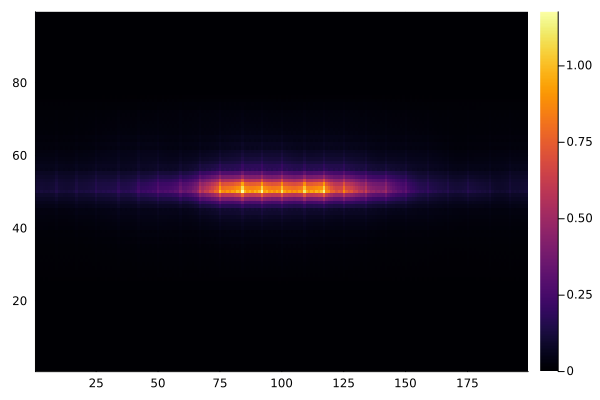

In [138]:
heatmap(smearedoldedist)

In [147]:
skymap = anglesmear_realeres(10^(-13.5),  21.502669052064256, 2.881127067633951, 7, 100)

99×199 Matrix{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]                                                                                                                                                                                      …  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]                                                                                                                                                                                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]                                                                              

In [164]:
asnull = [zeros(99, 199) for i in 1:25]
asalt = [zeros(99, 199) for i in 1:25]

for i in 1:25
    for j in 1:99
        for k in 1:199
            asnull[i][j, k] = skymapnull[j, k][i]
            asalt[i][j, k] = skymap[j, k][i]
        end
    end
end
skymappingnull = sum(asnull)
skymappingalt = sum(asalt)

99×199 Matrix{Float64}:
  0.0           0.0           0.0          …   0.0           0.0
  0.0           0.0          -1.78037e-5      -1.77893e-5    0.0
  0.0          -1.65145e-5   -3.95477e-5      -3.95138e-5   -1.64994e-5
  0.0          -1.91644e-5    0.0              0.0          -1.91453e-5
  0.0          -4.5109e-6     0.0              0.0          -4.50573e-6
 -7.29244e-7    0.0          -7.30685e-7   …  -4.49257e-7   -2.78672e-7
 -8.06948e-8    0.0          -8.08881e-8      -8.0491e-8     0.0
 -6.08385e-9   -7.95802e-10  -5.30654e-9      -5.27413e-9   -7.90159e-10
 -3.10579e-10  -3.11814e-10  -7.69442e-11     -7.57874e-11  -3.09237e-10
 -1.06666e-11  -1.07157e-11  -1.07771e-11     -1.05821e-11  -1.05986e-11
 -2.43738e-13  -2.43585e-13  -2.42888e-13  …  -2.38185e-13  -2.40909e-13
 -1.03339e-14  -9.99431e-15  -9.44002e-15     -9.48544e-15  -1.00517e-14
 -2.43747e-16  -2.04424e-16  -2.24162e-16     -2.74697e-16  -2.21613e-16
  ⋮                                        ⋱           

In [169]:
residue = abs.((skymappingnull .- skymappingalt) ./ skymappingnull)

99×199 Matrix{Float64}:
 NaN           NaN          NaN         …  NaN         NaN
 NaN           NaN            0.128036       0.128116  NaN
 NaN             0.128615     0.128271       0.128356    0.128708
 NaN             0.129087   NaN            NaN           0.129191
 NaN             0.130004   NaN            NaN           0.130129
   0.131256    NaN            0.131057  …    0.131763    0.131025
   0.133096    NaN            0.132823       0.133419  NaN
   0.135991      0.137462     0.135323       0.136097    0.138374
   0.140672      0.140151     0.141515       0.143413    0.141203
   0.147306      0.146978     0.146567       0.148506    0.14809
   0.148112      0.150732     0.1547    …    0.153728    0.149709
   0.104747      0.121734     0.148315       0.130136    0.109205
   0.0339171     0.0586158    0.275376       0.148687    0.00420928
   ⋮                                    ⋱              
   0.00578139    0.236906     1.82737        0.7401      0.0679655
   0.363002    

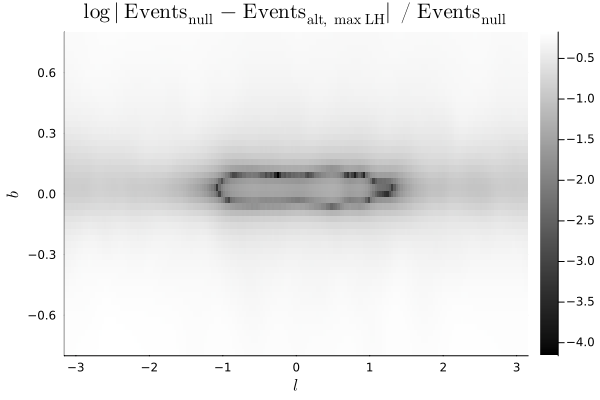

In [176]:
heatmap(
    range(-π, π, 199),
    range(-π/4, π/4, 51),
    log10.(residue[25:75, :]),
    xlabel=L"l",
    ylabel=L"b",
    title=L"\log~|\mathrm{Events}_{\mathrm{null}} - \mathrm{Events}_{\mathrm{alt,~max~LH}}|~/~\mathrm{Events}_{\mathrm{null}}",
    c=:greys
)

In [440]:
mxlhallsky = allskymaxlh_realeres(10^(-14), 1.8) # Setting the angular bin size to be constant at 1.8 degrees²
allskymaxparams = Optim.minimizer(mxlhallsky)

askyevents_alt = anglesmear_realeres(10^(-14), 21.8, 2.7, 7, 100)
askyevents_alt_maxlh = anglesmear_realeres(10^(-14), allskymaxparams[1], allskymaxparams[2], 7, 100)

99×199 Matrix{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]                                                                                                                                                                                     …  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]                                                                                                                                                                                        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]                                                                                

In [220]:
askyevents_null = anglesmear_realeres(0, 21.8, 2.7, 7, 100)

99×199 Matrix{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]                                                                                                                                                                                      …  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]                                                                                                                                                                                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]                                                                              

In [70]:
mxlhallskynew = allskymaxlh_realeres(10^(-13.5), 1.8) # Setting the angular bin size to be constant at 1.8 degrees²
allskymaxparamsnew = Optim.minimizer(mxlhallsky)

askyevents_nullnew = anglesmear_realeres(0, 21.8, 2.7, 7, 100)
askyevents_altnew = anglesmear_realeres(10^(-13.5), 21.8, 2.7, 7, 100)
askyevents_alt_maxlhnew = anglesmear_realeres(10^(-13.5), allskymaxparams[1], allskymaxparams[2], 7, 100)

99×199 Matrix{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]                                                                                                                                                                                      …  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]                                                                                                                                                                                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]                                                                              

In [146]:
allskymaxparamsnew

2-element Vector{Float64}:
 21.502669052064256
  2.881127067633951

In [441]:
bsize, lsize = size(askyevents_null)
ts_vals = zeros(bsize, lsize)

for j in 1:lsize
    for i in 1:bsize
        ts_vals[i, j] = lrt(askyevents_null[i, j], askyevents_alt_maxlh[i, j])
    end
end

sum(ts_vals)

23.233162327073742

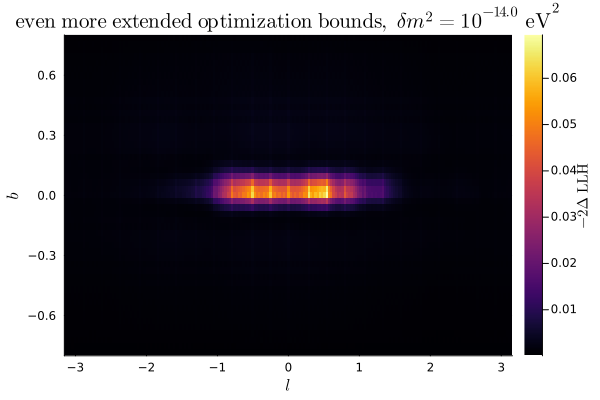

In [445]:
heatmap(
    range(-π, π, 199),
    range(-π/4, π/4, 51),
    ts_vals[25:75, :],
    xlabel=L"l",
    ylabel=L"b",
    title=L"\mathrm{even~more~extended~optimization~bounds},~\delta m^2 = 10^{-14.0}~\mathrm{eV}^2",
    colorbar_title=L"-2\Delta~\mathrm{LLH}"
)

In [75]:
asnull = [zeros(99, 199) for i in 1:25]
asalt = [zeros(99, 199) for i in 1:25]
asaltmaxlh = [zeros(99, 199) for i in 1:25]

for i in 1:25
    for j in 1:99
        for k in 1:199
            asnull[i][j, k] = askyevents_nullnew[j, k][i]
            asalt[i][j, k] = askyevents_altnew[j, k][i]
            asaltmaxlh[i][j, k] = askyevents_alt_maxlhnew[j, k][i]
        end
    end
end


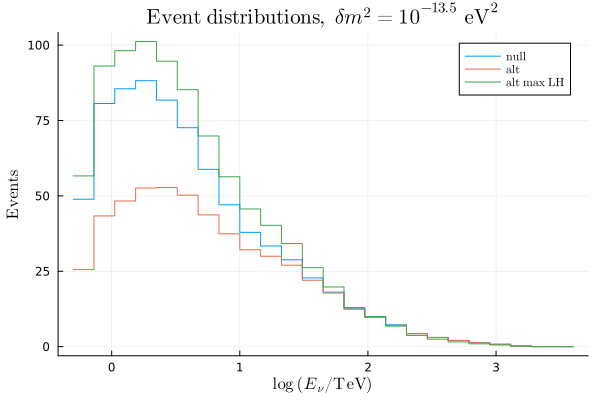

In [111]:
plot(
    binned_us,
    [sum(askyevents_nullnew) sum(askyevents_altnew) sum(askyevents_alt_maxlhnew)],
    seriestype=:step,
    label=[L"\mathrm{null}" L"\mathrm{alt}" L"\mathrm{alt~max~LH}"],
    ylabel=L"\mathrm{Events}",
    xlabel=L"\log~(E_{\nu} / \mathrm{TeV})",
    title=L"\mathrm{Event~distributions},~\delta m^2 = 10^{-13.5}~\mathrm{eV^2}"
)

In [188]:
bs = range(-π, π, 99)

bs[62]

# pi/4

0.7693696294505615

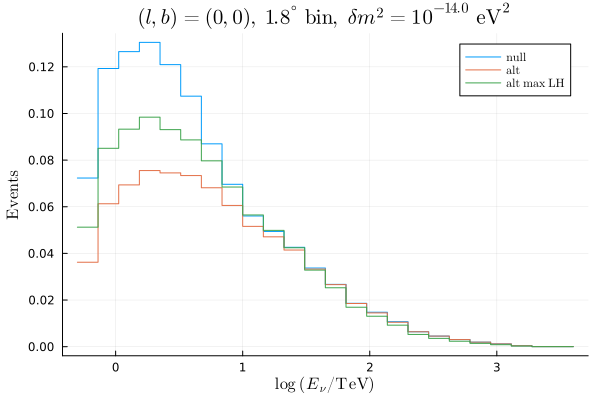

In [444]:
row = 50
col = 100
plot(
    binned_us,
    [askyevents_null[row,col] askyevents_alt[row,col] askyevents_alt_maxlh[row,col]],
    seriestype=:step,
    label=[L"\mathrm{null}" L"\mathrm{alt}" L"\mathrm{alt~max~LH}"],
    ylabel=L"\mathrm{Events}",
    xlabel=L"\log~(E_{\nu} / \mathrm{TeV})",
    title=L"(l, b) = (0, 0),~1.8^{\circ}~\mathrm{bin},~\delta m^2 = 10^{-14.0}~\mathrm{eV^2}"
)

In [119]:
sum(sum(askyevents_null))

746.07306573618

In [30]:
logdm2s = range(-15, -12, 20)
dm2s = 10 .^ logdm2s

tsvals = [allskyts_realeres(dm2, 7) for dm2 in dm2s]

20-element Vector{Float64}:
  0.20408507110865348
  0.7894852838666327
  2.7370650928275633
  7.693845416712804
 16.11271029430426
 27.105634110054638
 39.195612735332574
 47.45161739471665
 49.65842290600908
 45.61678797288194
 38.68260367766979
 31.31166240205897
 25.618808883081464
 21.64582286588689
 19.075417941998587
 17.128548351392126
 15.358641212805681
 12.525617707434774
 10.314584742657742
  7.83903209649357

In [32]:
logdm2s1 = range(-12, -11, 7)
dm2s1 = 10 .^ logdm2s1
tsvals1 = [allskyts_realeres(dm2, 7) for dm2 in dm2s1]


7-element Vector{Float64}:
 7.83903209649357
 5.7971274437283125
 3.9443842184869613
 2.919488664353577
 1.6778081873693944
 1.6273554710771698
 0.8445453138547616

In [39]:
logdm2s = range(-15, -11, 100)
dm2s = 10 .^ logdm2s
tsvals = [allskyts_realeres(dm2, 7) for dm2 in dm2s]

100-element Vector{Float64}:
 0.20408507110865348
 0.29033126561687084
 0.41166255092734894
 0.5806838987316671
 0.8143052163476026
 1.133926683249586
 1.565296442304884
 2.1396437556917514
 2.889864458919578
 3.8484630760941596
 5.043026421247812
 6.489218079968921
 8.187631338028552
 ⋮
 2.210090661481188
 2.090216392065759
 2.2466236919764846
 2.152546027588425
 1.5975096063994996
 1.177314431006699
 1.1442442955830883
 1.3521532776236616
 1.8050020532248767
 1.7846630054958466
 0.9200376308051235
 0.8445453138547616

In [35]:
alllogdm2s = unique(vcat(logdm2s, logdm2s1))
alltsvals = unique(vcat(tsvals, tsvals1))

26-element Vector{Float64}:
  0.20408507110865348
  0.7894852838666327
  2.7370650928275633
  7.693845416712804
 16.11271029430426
 27.105634110054638
 39.195612735332574
 47.45161739471665
 49.65842290600908
 45.61678797288194
 38.68260367766979
 31.31166240205897
 25.618808883081464
 21.64582286588689
 19.075417941998587
 17.128548351392126
 15.358641212805681
 12.525617707434774
 10.314584742657742
  7.83903209649357
  5.7971274437283125
  3.9443842184869613
  2.919488664353577
  1.6778081873693944
  1.6273554710771698
  0.8445453138547616

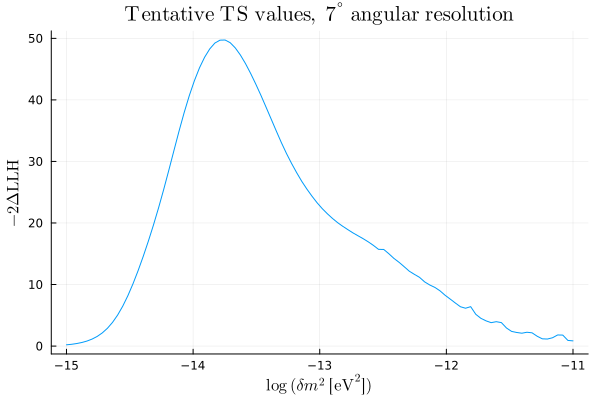

In [40]:
plot(
    logdm2s,
    tsvals,
    title=L"\mathrm{Tentative~TS~values},~7^{\circ}~\mathrm{angular~resolution}",
    label=false,
    xlabel=L"\log~(\delta m^2~[\mathrm{eV^2}])",
    ylabel=L"-2\Delta \mathrm{LLH}"

)

In [15]:
plot(binned_us, 
     asmearbinned[13, 25], 
     seriestype=:step
)

LoadError: UndefVarError: `asmearbinned` not defined